In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import json

# Graph libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir = './data/'
image_dir = './images/'
df = pd.read_csv(data_dir+'user_features.csv')
categorical_features = ['location', 'description', 'url', 'verified', 'protected']
continuous_features = ['listed_count', 'name_containment', 'account_age_days', 
                       'followers_per_day', 'tweets_per_day', 'following_per_day', 'followers_to_friends' ] 
df.head()

,target,listed_count,location,description,protected,url,verified,name_containment,account_age_days,followers_per_day,tweets_per_day,following_per_day,followers_to_friends
0,1,0,1,1,0,1,0,0.500000,1344,0.0141,0.0216,0.1897,0.074510
1,1,0,0,0,0,0,0,0.333333,1337,0.1556,1.0531,0.6477,0.240185
2,1,0,1,1,0,1,0,1.000000,1242,0.0475,0.0314,0.7746,0.061331
3,1,0,1,0,0,0,0,0.000000,1213,0.0058,0.0486,0.0404,0.142857
4,1,1,1,1,0,1,0,1.000000,1184,0.0507,0.8336,0.4400,0.115163


The first step is to check if we have a class imbalance i.e one class is better represented than the other. A class imbalance can lead to our model having poor predictive performance for the minority class.

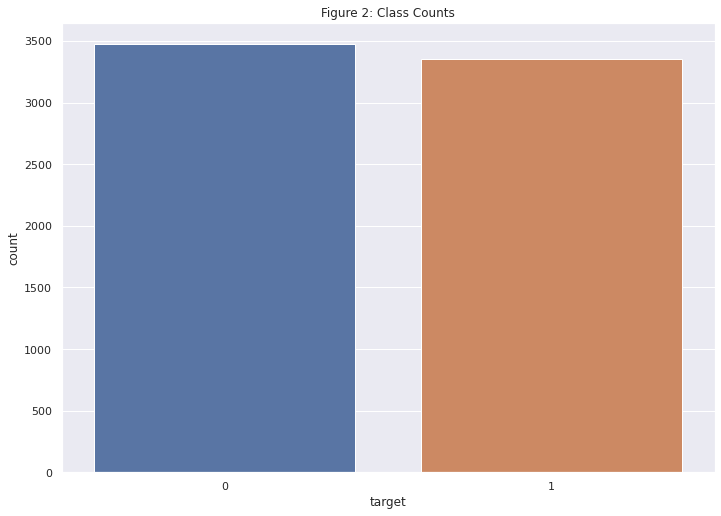

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="target", data=df).set_title('Figure 2: Class Counts')

In [4]:
ax.figure.savefig(image_dir+'class_counts.png')

Figure 1 shows a silght imbalance between the classes genuine account (0) and fake follower (1), which is not a concern meaning we shouldn't have to employ oversampling or resampling techniques.

## Categorical Features

In [5]:
#Work out % of each
temp_df = df.groupby(['target'], as_index=True).agg({'location': ['sum', 'count']})
temp_df['%_of_total'] = round(temp_df['location']['sum']/temp_df['location']['count'], 2)
temp_df

location       %_of_total
            sum count           
target                          
0          2365  3474       0.68
1          2776  3351       0.83

In [6]:
# liitle sanity check
print("""
    categorical feature: Location
    percentage of total class 0: {class_0}
    percentage of total class 1: {class_1}
""".format(class_0=temp_df['%_of_total'][0], class_1=temp_df['%_of_total'][1]))


    categorical feature: Location
    percentage of total class 0: 0.68
    percentage of total class 1: 0.83



In [7]:
def build_aggregates(orig_df, cat_var):
    temp_df = orig_df.groupby(['target'], as_index=True).agg({cat_var: ['sum', 'count']})
    temp_df['%_of_total'] = round(temp_df[cat_var]['sum']/temp_df[cat_var]['count'], 2)
    return cat_var, temp_df['%_of_total'][0], temp_df['%_of_total'][1]

data = []
# build up a list of % of totals for each cat feature to plot below
for feature in categorical_features:
    cat_var, class_0, class_1 = build_aggregates(df, feature)
    data.append([cat_var, class_0, class_1])
    
agg_df = pd.DataFrame(data, columns=['feature_name', 'class_0', 'class_1'])
agg_df.head()

,feature_name,class_0,class_1
0,location,0.68,0.83
1,description,0.89,0.68
2,url,0.36,0.03
3,verified,0.00,0.00
4,protected,0.02,0.00


In [8]:
agg_df.style.background_gradient(cmap='RdYlGn', axis=1)


,feature_name,class_0,class_1
0,location,0.680000,0.830000
1,description,0.890000,0.680000
2,url,0.360000,0.030000
3,verified,0.000000,0.000000
4,protected,0.020000,0.000000


In [9]:
temp_df = df.groupby(['target'], as_index=True).agg({'verified': ['sum', 'count']})
temp_df['%_of_total'] = round(temp_df['verified']['sum']/temp_df['verified']['count'], 2)
temp_df

verified       %_of_total
            sum count           
target                          
0            11  3474        0.0
1             0  3351        0.0

From the table above it is apparent that fake followers are mor eliley to have a location, whereas genuine users are more likley to have a description and a URL in their profile. It is also apparent that verified users are under represented in our dataset, a total of 11 genuine users.

## continuous_features
### correlation plot

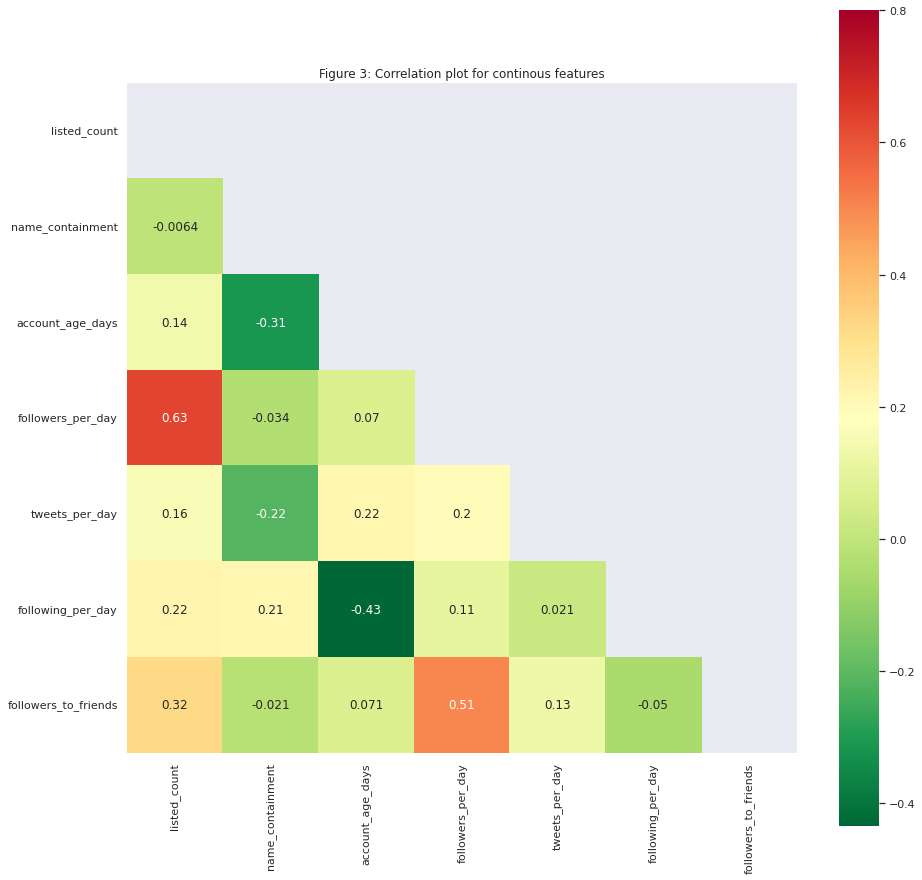

In [10]:
C_mat = df[continuous_features].corr()
matrix = np.triu(C_mat)
fig = plt.figure(figsize = (15,15))
ax = sns.heatmap(C_mat, vmax = .8, square = True, annot=True, cmap='RdYlGn_r', mask=matrix) \
    .set_title('Figure 3: Correlation plot for continous features')
#plt.show()

In [11]:
ax.figure.savefig(image_dir+'corr_plot.png')

Figure 2 shows that our strongest correlations are between followers_per_day vs listed_count and followers_to_friends vs followers_perday, 0.61 and 0.51 respectively. 

A study by Dormann, C. F., J. Elith, S. Bacher, et al. 2013 suggest a correlation threshold of r>0.7 as the cut off for multicollinearity, with this in mind all continuous features where shown to have a satisfactory correlation.

* **reference:** Dormann, C. F., J. Elith, S. Bacher, et al. 2013. Collinearity: a review of methods to deal with it and a simulation study evaluating their performance. Ecography 36:27–46.

### Pair Plot

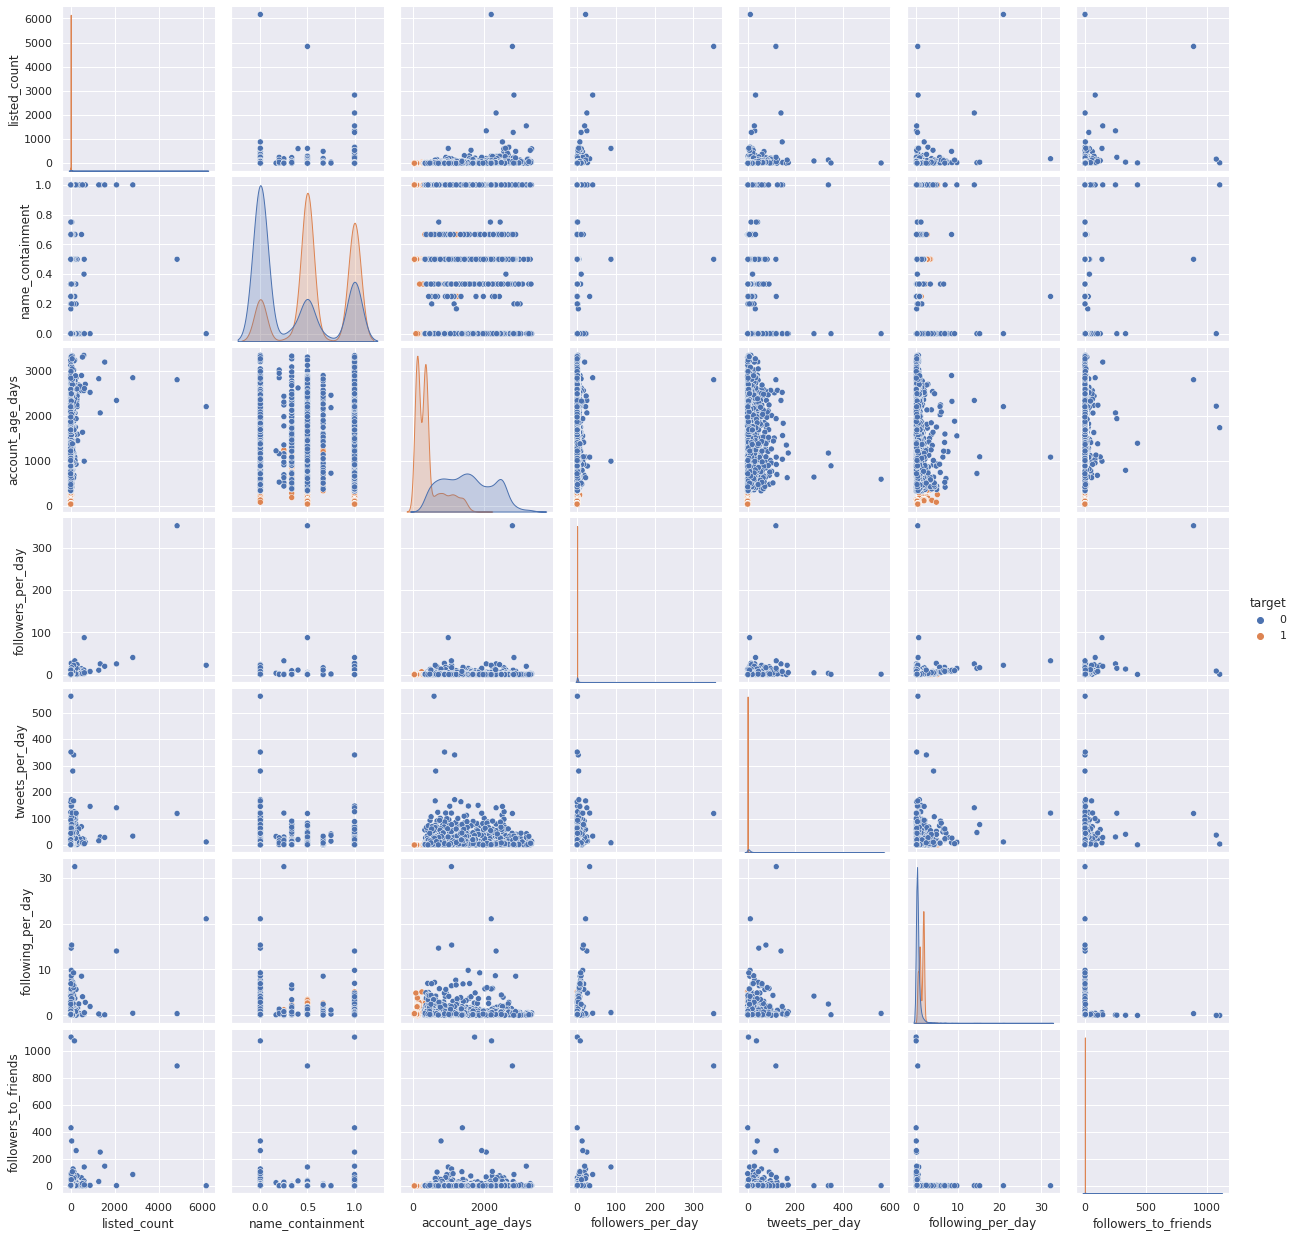

In [12]:
sns.pairplot(df[continuous_features+['target']], hue="target")

### Interesting KDEs

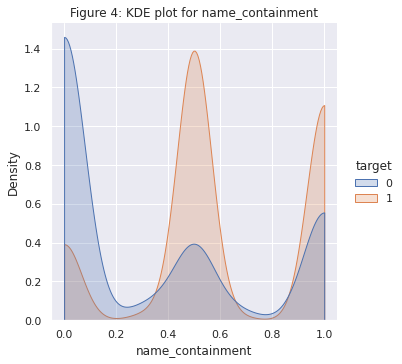

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.displot(df[['name_containment', 'target']], x="name_containment", hue="target", kind="kde", fill=True, cut=0) \
    .set(title='Figure 4: KDE plot for name_containment')

In [14]:
ax.figure.savefig(image_dir+'name_containment.png')

Figure 4 suggests fake followers (0) tend to have higher name_containment, meaning the username and the name of the account contain the same strings. This is expected as Twitter suggests a username similar to the name privided when signing up. When making a large number of bots it would be a costly extra step to make both of these orginal.

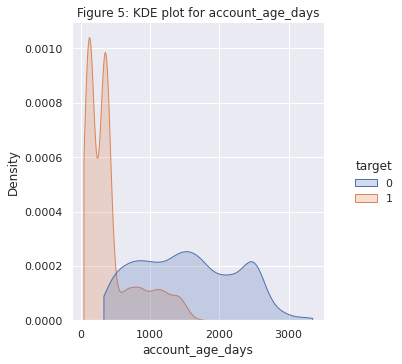

In [15]:
ax = sns.displot(df[['account_age_days', 'target']], x="account_age_days", hue="target", kind="kde", fill=True, cut=0) \
    .set(title='Figure 5: KDE plot for account_age_days')

In [16]:
ax.figure.savefig(image_dir+'account_age_days.png')

Figure 5 shows fake followers (1) tend to have younger accounts when compared to genuine users (0). Twitter often purges bot traffic from their user base meaning bot accounts tend not to last as long

[None]

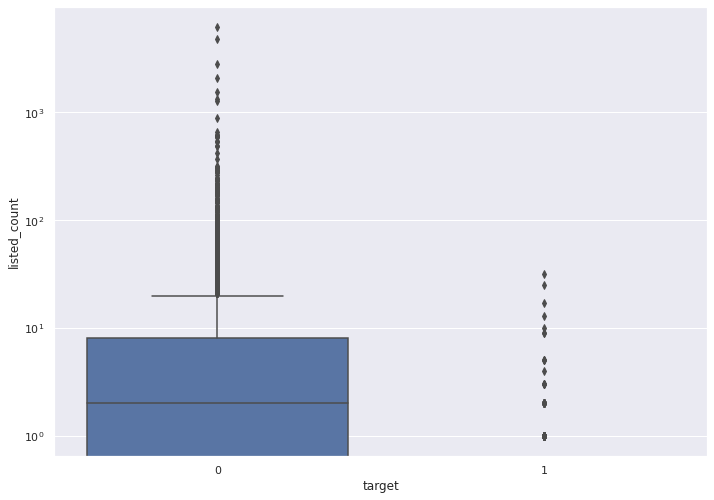

In [17]:
sns.boxplot(x="target", y='listed_count', data=df[['listed_count']+['target']]).set(yscale="log")

[None]

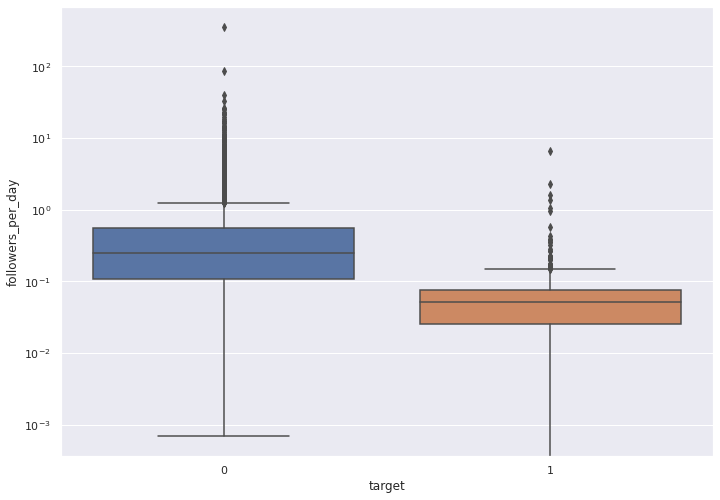

In [18]:
sns.boxplot(x="target", y='followers_per_day', data=df[['followers_per_day']+['target']]).set(yscale="log")


[None]

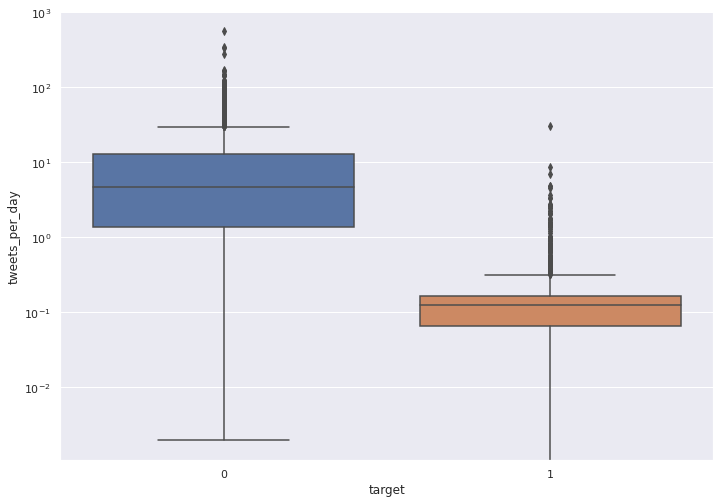

In [19]:
ax = sns.boxplot(x="target", y='tweets_per_day', data=df[['tweets_per_day']+['target']])
ax.set(yscale="log")



[None]

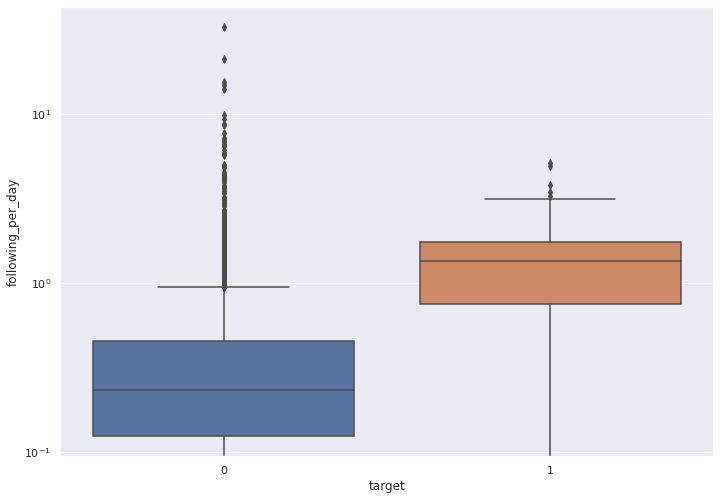

In [20]:
sns.boxplot(x="target", y='following_per_day', data=df[['following_per_day']+['target']]).set(yscale="log")


[None]

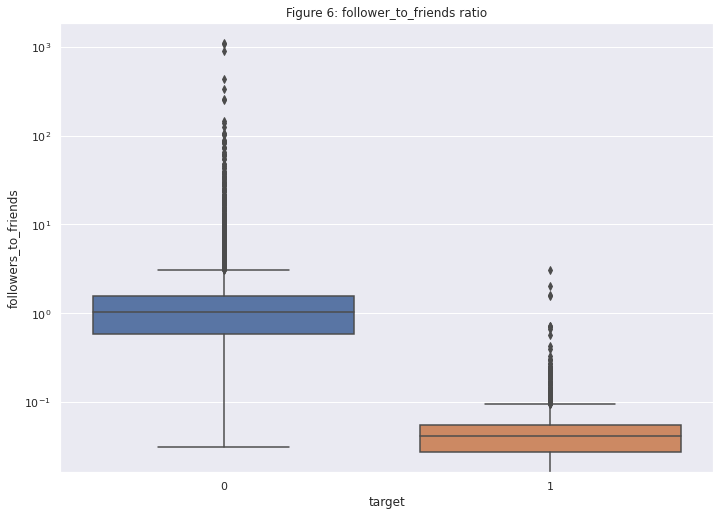

In [21]:
ax=sns.boxplot(x="target", y='followers_to_friends' ,data=df[['followers_to_friends']+['target']])
ax.set_title('Figure 6: follower_to_friends ratio')
ax.set(yscale="log")

# Model Selection

A brief stuudy using various models to asses which model will work best for our application

In [22]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE=0.8
data_dir = './data/'
df = pd.read_csv(data_dir+'user_features.csv')
# 4 observations have nan for follower_to_friends and one inf, we will drop those
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
# first shuffle the data, even though teh train test split function pics randomly
df = df.sample(frac=1)

# split the data in train and test
X = df.drop(columns = ['target']).copy()
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=TRAIN_SIZE)

print("""
    X_train: {X_train} 
    y_train: {y_train}
============================
    X_test: {X_test}
    y_test: {y_test}

""".format(X_train=X_train.shape,y_train=y_train.shape,
          X_test=X_test.shape, y_test=y_test.shape ))


    X_train: (5456, 12) 
    y_train: (5456,)
    X_test: (1364, 12)
    y_test: (1364,)




In [23]:
#Check if we have nans
df.isnull().sum()

target                  0
listed_count            0
location                0
description             0
protected               0
url                     0
verified                0
name_containment        0
account_age_days        0
followers_per_day       0
tweets_per_day          0
following_per_day       0
followers_to_friends    0
dtype: int64

## Test 4 models
models from the orginal study alongside a random forrest were assesed using accuracy ast the main evaulation metric

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# DF for results
result_df = pd.DataFrame(columns=['model_name', 'accuracy_mean', 'accuracy_std'])
models = [RandomForestClassifier(random_state=0), 
          SVC(kernel="linear", C=1, random_state=0), 
          LogisticRegression(random_state=0, max_iter=1000),
          KNeighborsClassifier(n_neighbors=2)]
model_names = ['RandomForestClassifier', 'SVC', 'LogisticRegression', 'KNeighborsClassifier']

for i,model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train,  cv=5, scoring='accuracy')
    result_df = result_df.append(pd.Series([model_names[i], scores.mean(), scores.std()], index=result_df.columns), ignore_index=True)

In [25]:
result_df.style.background_gradient(cmap='RdYlGn')

,model_name,accuracy_mean,accuracy_std
0,RandomForestClassifier,0.989735,0.002683
1,SVC,0.982770,0.002279
2,LogisticRegression,0.981671,0.002248
3,KNeighborsClassifier,0.920820,0.008657


In [26]:
# DF for results
result_df = pd.DataFrame(columns=['model_name', 'roc_auc_mean', 'accuracy_std'])
models = [RandomForestClassifier(random_state=0), 
          SVC(kernel="linear", C=1, random_state=0), 
          LogisticRegression(random_state=0, max_iter=1000),
          KNeighborsClassifier(n_neighbors=2)]
model_names = ['RandomForestClassifier', 'SVC', 'LogisticRegression', 'KNeighborsClassifier']

for i,model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train,  cv=5, scoring='roc_auc')
    result_df = result_df.append(pd.Series([model_names[i], scores.mean(), scores.std()], index=result_df.columns), ignore_index=True)

In [27]:
result_df.style.background_gradient(cmap='RdYlGn')

,model_name,roc_auc_mean,accuracy_std
0,RandomForestClassifier,0.998904,0.000962
1,SVC,0.995883,0.001790
2,LogisticRegression,0.996240,0.001853
3,KNeighborsClassifier,0.952015,0.007147


RandomForestClassifier (RF) was found to have the highest accuracy (99%) and lowest standard deviation in accuracy scores (0.0023), further to this RF exhibited the highest "roc_auc" score (area under receiver operator curve) meaning RF was able to maximise true positives whilst minimising false positives.


For this reason, the Random Forrest model was chosen to proceed with.


# Feature Selection
Recursive Feature Elimination (RFE) was chosen as our feature selection method, in particular, the Boruta algorithm was used. RFE has advantages over feature importance methods as it doesn’t require the user to select features based on an arbitrary feature importance threshold. 


### Run to get Boruta

In [28]:
# Run this cell if Boruta is not present
import sys
!{sys.executable} -m pip install boruta

     |████████████████████████████████| 56 kB 6.1 MB/s             


In [29]:
from boruta import BorutaPy


# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(random_state=0)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train.values, y_train.values)

# Zip everything up to print out suggestions
feature_ranks = list(zip(X_train.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	2
Iteration:

In [30]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train.values)

# rerun our analysis to see effect on accuracy
result_df = pd.DataFrame(columns=['model_name', 'accuracy_mean', 'accuracy_std'])
models = [RandomForestClassifier(random_state=0)]
model_names = ['RandomForestClassifier']

for i,model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train,  cv=5, scoring='accuracy')
    result_df = result_df.append(pd.Series([model_names[i], scores.mean(), scores.std()], index=result_df.columns), ignore_index=True)

In [31]:
result_df

,model_name,accuracy_mean,accuracy_std
0,RandomForestClassifier,0.989735,0.002683


Results from Boruta suggest we can remove "verified" and "protected" as they do not influence our accuracy score. Both these features would usually be attributed to a real user. Verified users are accounts that command significant influence (influencers) where the verified blue tick for which one must apply serves as a badge to confirm the account is who they say they are. Similarly, protected accounts can only be viewed by certain people, a trait one would associate with a real user. Both of these features are underrepresented in our dataset, to have the model learn the importance of these features we would need to oversample accounts containing them.


### Drop verified and protected from our Train and Test datsets

In [32]:
X_train = X_train.drop(['verified', 'protected'], axis=1)
X_test = X_test.drop(['verified', 'protected'], axis=1)
print("""
    X_train: {X_train} 
    y_train: {y_train}
============================
    X_test: {X_test}
    y_test: {y_test}

""".format(X_train=X_train.shape,y_train=y_train.shape,
          X_test=X_test.shape, y_test=y_test.shape ))


    X_train: (5456, 10) 
    y_train: (5456,)
    X_test: (1364, 10)
    y_test: (1364,)




In [33]:
# sanity check: both columns were removed
X_train.head()

,listed_count,location,description,url,name_containment,account_age_days,followers_per_day,tweets_per_day,following_per_day,followers_to_friends
5427,0,0,1,0,0.000000,477,0.8973,20.1782,0.8260,1.086294
4611,1,1,1,1,0.500000,656,0.1311,0.2896,0.3415,0.383929
4150,0,0,0,0,0.000000,1338,0.2040,3.6555,0.2138,0.954545
1621,0,1,1,0,0.500000,119,0.0588,0.1513,1.6807,0.035000
160,0,1,0,0,0.333333,1307,0.0008,0.0000,0.3864,0.001980


## Save data to csv

In [34]:
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    # your code here
    df = pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
    df.to_csv('{data_dir}/{filename}'.format(data_dir=data_dir, filename=filename), header=False, index=False)
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [35]:
make_csv(X_train, y_train, filename='model/train.csv', data_dir=data_dir)
make_csv(X_test, y_test, filename='model/test.csv', data_dir=data_dir)

Path created: ./data//model/train.csv
Path created: ./data//model/test.csv
